## Gradient Descent with Momentum on All Pair-wise MNIST Digit Recognition



### Objectives

We build upon the earlier experiment of *Gradient Descent and Variants on MNIST Digit Recognition* and look at the error rate of all pair-wise digit recognition via the Gradient Descent with Momenum optmization method.

###### Data

The data is the classic [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The dataset is a collection of images of single digits $\{0,1,2,3,4,5,6,7,8,9\}$. The training set has $60,000$ examples and the test set has $10,000$ examples. Further information can be found on the [website](http://yann.lecun.com/exdb/mnist/).

##### Contents

1. [The Problem](#Problem) <br>
    1.1. [Derivation of the Problem](#Derivation) <br>
    1.2. [Gradient Descent and Variants](#GD_Momentum) <br>
2. [Code Implementation](#Code) <br>
    2.1. [Packages and Data Loading](#Loading) <br>
    2.2. [Helper Functions](#Helper_Functions) <br>
    2.3. [Main Functions, Gradient Descent with Momentum](#Main_Functions) <br>
    2.4. [Model Building](#Model_Building) <br>


<br/>

### 1.  <a id = 'Problem'> The Problem </a>

#### 1.1.  <a id = 'Derivation'> Derivation of the Problem </a>

We will model this as a binary classification problem: we will built model to predict between every 2 digits. Put formally, suppose we have some data points $\{x_i, y_i\}_{i=1}^N \in \mathbb{R}^d \times \mathbb{R}$, where $x_i$ is the feature vector (in this case a $784$-dimension vector of pixel values), $y_i \in \{-1,1\}$ is the class label, and $N$ is the number of training points.

Given $(x_i, y_i)$, we will model $y_i = sign(w^T x_i)$, where $w \in \mathbb{R}^d$ is the parameter we want to find. The associated cost function $F$ is thus

$$
    F(w) 
    \ = \ \frac{1}{N} \sum_{i=1}^N f_i(w)
    \ = \ \frac{1}{N} \sum_{i=1}^N \log\left( 1 + e^{-w^T x_i y_i} \right)
$$

where $f_i = \log\left( 1 + e^{-w^T x_i y_i} \right)$ be the loss associated with the $i^{th}$ data point $(x_i, y_i)$.

Given $F$, the gradient $\nabla_w F$ with respect to $w$ is thus

$$
    \nabla F
        \ = \ \frac{1}{N} \sum_{i=1}^N \nabla f_i
        \ = \ \left( \frac{1}{N} \sum_{i=1}^N \frac{- e^{- w^T x_i y_i} }{1 + e^{- w^T x_i y_i}} \left( x_i y_i \right) \right)
        \ = \ \left( \frac{1}{N} \sum_{i=1}^N \frac{ 1 }{1 + e^{w^T x_i y_i}} \left( - x_i y_i \right) \right)
$$

<br/>

#### 1.2.  <a id = 'GD_Momentum'> Gradient Descent with Momentum </a>

We recall the update rule in the __gradient descent__ algorithm: given the current weight $w^t$, we update it as

$$
    w^{(t+1)}
    \ = \ w^t - \alpha_t \sum_{i=1}^k \nabla f_i(w^t)
$$

where if $k = N$, we have the base *gradient descent*, $k = 1$ *stochastic gradient descent*, and $1 < k < N$ (common choices include $k = 16$ or $32$) *minibatch gradient descent*. Without loss of generality, suppose we start with minibatch gradient descent, we can boost the convergence with *momentum*:

$$w^{(t+1)} \ = \ w^t - \left( \alpha_t \sum_{i=1}^k \nabla f_i(w^t) \right) + \beta_t\left( x^t - x^{(t-1)} \right)$$


<br/>

### 2.  <a id = 'Code'> Code Implementation </a>

#### 2.1.  <a id = 'Loading'> Packages and Data Loading </a>

We first load the necessary packages.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import time
from IPython.display import Image

We now load the datasets and rename `Label` column.

In [2]:
data_train = pd.read_csv('mnist_train.csv', header=None)
data_test = pd.read_csv('mnist_test.csv', header=None)
data_train.rename(columns={ data_train.columns[0]: "Label" }, inplace = True)
data_test.rename(columns={ data_test.columns[0]: "Label" }, inplace = True)

In [3]:
print('-----------------------------' + '\n' + 'Number of observations per digits' + '\n' + '-----------------------------')
print('\n' + '-----------------------------' + '\n' + 'Train set:')
print(np.array(np.unique(data_train['Label'], return_counts=True)))
print('\n' + '-----------------------------' + '\n' + 'Test set:')
print(np.array(np.unique(data_test['Label'], return_counts=True)))

-----------------------------
Number of observations per digits
-----------------------------

-----------------------------
Train set:
[[   0    1    2    3    4    5    6    7    8    9]
 [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]]

-----------------------------
Test set:
[[   0    1    2    3    4    5    6    7    8    9]
 [ 980 1135 1032 1010  982  892  958 1028  974 1009]]


<br/>

#### 2.2.  <a id = 'Helper_Functions'> Helper Functions </a>

We write some functions for later use:

*  `getData(df, digits, n)` to get `n` random observations from the data set `df` with desired digits `digits`
*  `loss_fn(df, w)` to compute the loss on the data set `df` given current weight `w`
*  `grad_F(df, w)` to compute the gradient given the training points `df` and current weight `w`
*  `getError(df, w)` to compute the *error rate* on the data set `df` given current weight `w`
*  `plot` to plot the training losses

`getData(df,digits,n)`

In [4]:
def getData( df, digits, n ):
    
    # Shuffle observations
    indices = np.arange(df.shape[0])
    np.random.shuffle(indices)
    df = df.iloc[indices]
    
    # Get observations based on wanted digits
    data = df[df['Label'].isin(digits)].groupby('Label').head(n)
    
    # Set the labels to {-1,1}
    data['Label'] = np.sign( data['Label'] - sum(digits)/len(digits) )
    
    return data

`plot(loss, plt_alpha, plt_color, plt_label)`

In [5]:
def plot(loss, plt_alpha, plt_color, plt_label):
    plt.plot(idx, loss, '-', color = plt_color, alpha = plt_alpha, 
         label = plt_label)

`loss_fn(df, w)`

In [6]:
def loss_fn(df, w):
    
    # Get appropriate data points & labels
    X = df.drop('Label', axis = 1) / 255
    Y = df['Label']
    
    term_e = np.dot(w, X.transpose()) * Y
    term_e = np.exp(- term_e)
    term_log = np.log( 1 + term_e )

    return term_log.mean()

`getError(df,w)`

In [7]:
def getError(df,w):
    # Get appropriate data points & labels
    X = df.drop('Label', axis = 1) / 255
    Y = df['Label']
    # Prediction
    pred = np.sign(np.dot(X,w))
    # Error rate
    error = np.mean(pred != Y)
    return error

`grad_F(df, w)`

In [8]:
def grad_F(df, w):
    
    # Get appropriate data points & labels
    X = df.drop('Label', axis = 1) / 255
    Y = df['Label']
    N = len(Y)
    
    # Compute gradient of sum
    term_e = np.exp( np.dot( X, w ) * Y )
    term_e = np.array( 1/(1+term_e) * Y )
    # Reshape vector to matrix
    term_e = np.repeat(term_e, d).reshape( N, d )
    grad_mat = term_e * X
    grad = np.sum( grad_mat, axis = 0 )
    
    # Total gradient
    return - grad / N

<br/>

#### 2.3.  <a id = 'Main_Functions'> Main Functions, Gradient Descent with Momentum </a>

<br/>

`GD_Accelerated(df, w, k, alpha, beta, T, variant)`
*  `df, w`: training dataset and the initial $w^{(0)}$
*  `k`: the number of data points to be used per iterate
*  `alpha`: the step-size per iterate
*  `beta`: the momentum parameter
*  `T`: the number of iterate (aka the stopping criteria)
*  `variant`: to choose which variant: `momentum` or `Nesterov`

In [9]:
def GD_Accelerated( df, w, k, alpha, beta, T, variant ):
    
    loss_vector = [0]*T
    w_prv = w
    
    for t in range(0,T):
        loss_vector[t] = loss_fn( df, w )
        
        # Get sampled data points
        indices = np.random.choice( np.arange( df.shape[0] ), k, replace = False )
        data = df.iloc[indices]
        
        # Train model
        if variant == 'momentum':
            w_tmp = w - alpha * grad_F( data, w ) + beta * (w - w_prv)
        elif variant == 'Nesterov':
            w_mmt = w + beta * (w - w_prv)
            w_tmp = w_mmt - alpha * grad_F(data, w_mmt)
        else:
            print('Error: Acceleration not found')
            break
        
        w_prv = w
        w     = w_tmp
        
    return loss_vector, w

<br/>

#### 2.4.  <a id = 'Model_Building'> Model Building </a>

Let us now build a model for each pair of digits $\{x,y\}$ for $x,y \in \{0,1,\dots,9\}$. In other word, we would like to test how good our model is when predicting between any pair of digits.

In [10]:
T = 1000
alpha, beta = .0005, .8
k = 16

Time_matrix = np.zeros(10**2).reshape(10,10)
ErrTrain_matrix = np.zeros(10**2).reshape(10,10)
ErrTest_matrix = np.zeros(10**2).reshape(10,10)

for i in range(0,10):
    
    for j in range(0,10):
        
        if i>j:
            
            # Get dataset
            digits = [i,j]
            train = getData(data_train, digits, 2000)
            test = getData(data_test, digits, 500)
            d = train.shape[1] - 1
            
            # Train model
            start_time = time.perf_counter()
            w = np.zeros(d)
            loss, w_trained = GD_Accelerated( train, w, k, alpha, beta, T, 'momentum' )
            runtime = time.perf_counter() - start_time
            
            # Update Run time
            Time_matrix[i,j] = np.around( np.array([runtime]) / 60, 2)
            
            # Update Error rates
            ErrTrain_matrix[i,j] = round(getError( train, w_trained),4)
            ErrTest_matrix[i,j] = round(getError( test, w_trained),4)


In [11]:
print('-----------------------------' + '\n' + 'Total Run Time: ' + str(sum(sum(Time_matrix))) + ' minutes' + '\n' + '-----------------------------')
print(Time_matrix)

-----------------------------
Total Run Time: 55.120000000000005 minutes
-----------------------------
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.18 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.19 1.24 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.21 1.53 1.61 0.   0.   0.   0.   0.   0.   0.  ]
 [1.54 1.43 1.21 1.21 0.   0.   0.   0.   0.   0.  ]
 [1.18 1.37 1.37 1.2  1.21 0.   0.   0.   0.   0.  ]
 [1.42 1.4  1.24 1.18 1.2  1.18 0.   0.   0.   0.  ]
 [1.19 1.17 1.17 1.15 1.14 1.13 1.13 0.   0.   0.  ]
 [1.15 1.16 1.19 1.16 1.15 1.13 1.17 1.22 0.   0.  ]
 [1.17 1.18 1.08 1.15 1.19 1.16 1.16 1.16 1.16 0.  ]]


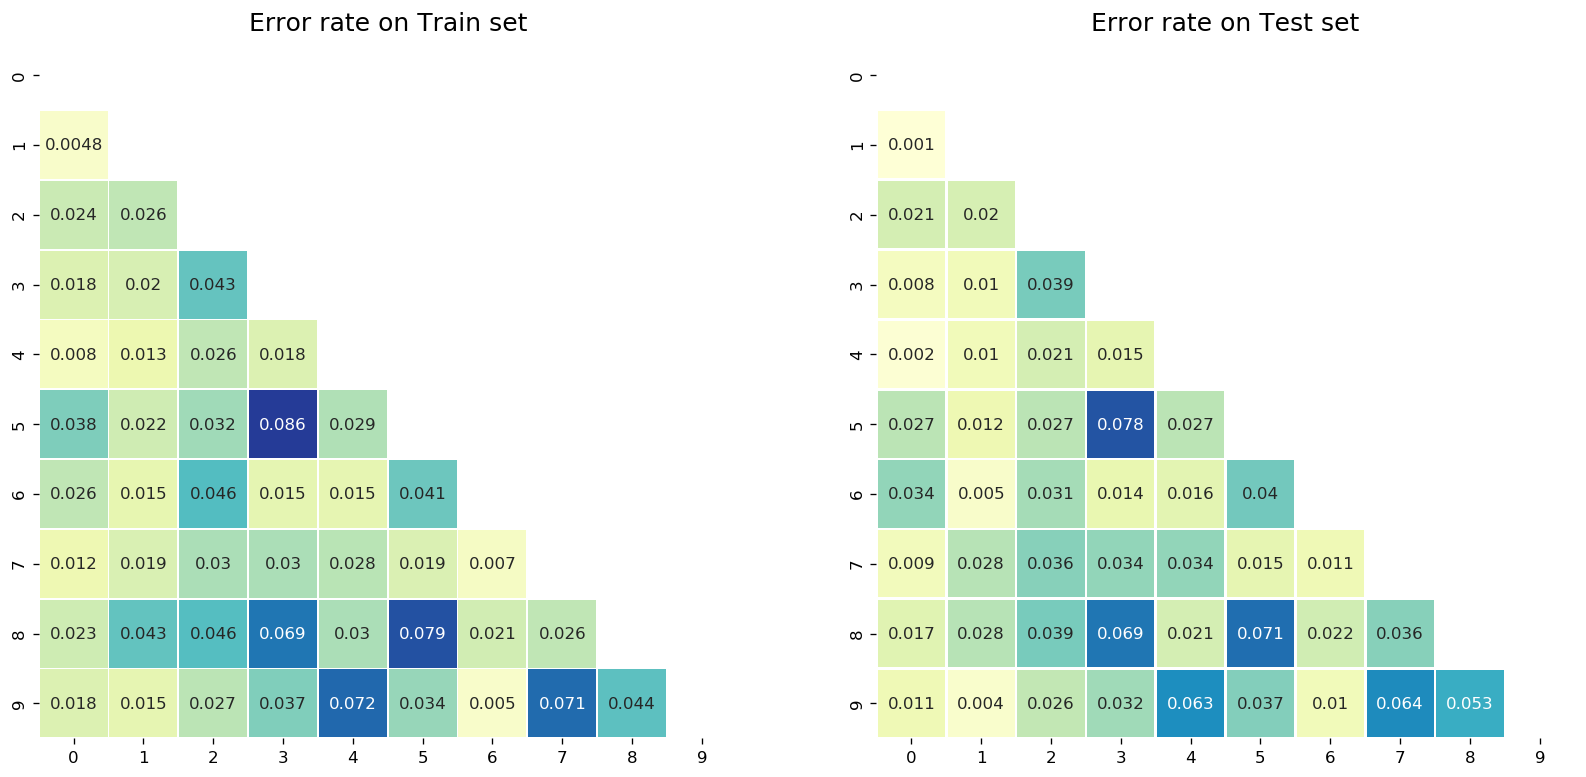

In [12]:
figure(num=None, figsize=(16, 8), dpi=120, facecolor='w', edgecolor='k')
plt.box(False)

plt.subplot(1, 2, 1)
mask = np.zeros_like(ErrTest_matrix)
mask[np.triu_indices_from(mask)] = True
# plt.imshow(ErrTrain_matrix)
sns.heatmap(ErrTrain_matrix, linewidth=0.5, mask = mask, vmax=.1, square=True,  cmap="YlGnBu", cbar=False, annot=True)
plt.title('Error rate on Train set', fontsize = 15)

plt.subplot(1, 2, 2)
mask = np.zeros_like(ErrTest_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(ErrTest_matrix, linewidth=1, mask = mask, vmax=.1, square=True,  cmap="YlGnBu", cbar=False, annot=True)
plt.title('Error rate on Test set', fontsize = 15)

plt.tight_layout()
plt.subplots_adjust(.1, .1, .9, .85, .2, .2)

plt.savefig('MNIST Digits - Pairwise Error Rate.png', bbox_inches='tight')